In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/ROIs1970_fall_s1_19_p924.png
/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/ROIs1868_summer_s1_59_p1060.png
/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/ROIs1970_fall_s1_29_p181.png
/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/ROIs1868_summer_s1_59_p771.png
/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/ROIs1970_fall_s1_113_p275.png
/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/ROIs1970_fall_s1_133_p912.png
/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/ROIs1868_summer_s1_59_p1206.png
/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/ROIs1970_fall_s1_113_p247.png
/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/ROIs1868_summer_s1_59_p361.png
/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/ROIs1868_summer_

In [2]:
pip install torch torchvision matplotlib


Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image
import os
from PIL import Image

# Generator Network: U-Net-like architecture
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super(UNetGenerator, self).__init__()

        def down_block(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        def up_block(in_feat, out_feat, dropout=0.0):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, stride=2, padding=1),
                      nn.BatchNorm2d(out_feat),
                      nn.ReLU(True)]
            if dropout:
                layers.append(nn.Dropout(dropout))
            return layers

        # Encoder
        self.down1 = nn.Sequential(*down_block(in_channels, 64, normalize=False))
        self.down2 = nn.Sequential(*down_block(64, 128))
        self.down3 = nn.Sequential(*down_block(128, 256))
        self.down4 = nn.Sequential(*down_block(256, 512))

        # Bottleneck
        self.bottleneck = nn.Sequential(*down_block(512, 512))

        # Decoder
        self.up1 = nn.Sequential(*up_block(512, 512, dropout=0.5))
        self.up2 = nn.Sequential(*up_block(1024, 256))
        self.up3 = nn.Sequential(*up_block(512, 128))
        self.up4 = nn.Sequential(*up_block(256, 64))

        # Output layer
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder path
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        # Bottleneck
        bn = self.bottleneck(d4)

        # Decoder path
        u1 = self.up1(bn)
        u2 = self.up2(torch.cat([u1, d4], 1))
        u3 = self.up3(torch.cat([u2, d3], 1))
        u4 = self.up4(torch.cat([u3, d2], 1))

        # Final output
        return self.final(torch.cat([u4, d1], 1))


In [4]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=4):  # SAR + colorized image as input
        super(Discriminator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        self.model = nn.Sequential(
            *block(in_channels, 64, normalize=False),
            *block(64, 128),
            *block(128, 256),
            *block(256, 512),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img_SAR, img_colored):
        img_input = torch.cat((img_SAR, img_colored), 1)
        return self.model(img_input)

# Loss functions
adversarial_loss = nn.MSELoss()
pixelwise_loss = nn.L1Loss()


In [5]:
class ImageDataset(Dataset):
    def __init__(self, sar_dir, color_dir, transform=None):
        self.transform = transform
        self.sar_dir = sar_dir
        self.color_dir = color_dir
        self.sar_images = sorted(os.listdir(self.sar_dir))
        self.color_images = sorted(os.listdir(self.color_dir))
        assert len(self.sar_images) == len(self.color_images), "SAR and color images folders must have the same number of files."

    def __getitem__(self, index):
        sar_image_path = os.path.join(self.sar_dir, self.sar_images[index])
        color_image_path = os.path.join(self.color_dir, self.color_images[index])

        sar_image = Image.open(sar_image_path).convert('L')  # Convert to grayscale for SAR
        color_image = Image.open(color_image_path).convert('RGB')  # Convert to RGB for color images

        if self.transform:
            sar_image = self.transform(sar_image)
            color_image = self.transform(color_image)

        return {'SAR': sar_image, 'color': color_image}

    def __len__(self):
        return len(self.sar_images)

In [6]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Subset

# Assuming ImageDataset, UNetGenerator, and Discriminator are already defined

def train_model(generator, discriminator, dataloader, epochs, lr=0.0002, lambda_pixel=100):
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for i, batch in enumerate(dataloader):
            img_SAR = batch['SAR'].to(device)
            img_color = batch['color'].to(device)

            # Generate fake color images
            gen_color = generator(img_SAR)

            # Get the output shape of the discriminator
            disc_out_shape = discriminator(img_SAR, gen_color).shape

            # Create valid and fake tensors with the same shape as discriminator output
            valid = torch.ones(disc_out_shape, requires_grad=False).to(device)
            fake = torch.zeros(disc_out_shape, requires_grad=False).to(device)

            # Train Generator
            optimizer_G.zero_grad()
            g_adv = adversarial_loss(discriminator(img_SAR, gen_color), valid)
            g_pixel = pixelwise_loss(gen_color, img_color)
            g_loss = g_adv + lambda_pixel * g_pixel
            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(img_SAR, img_color), valid)
            fake_loss = adversarial_loss(discriminator(img_SAR, gen_color.detach()), fake)
            d_loss = 0.5 * (real_loss + fake_loss)
            d_loss.backward()
            optimizer_D.step()

            print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations for the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Paths to the SAR and color folders in Kaggle's input directory
sar_folder = '/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/'
color_folder = '/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s2/'

# dataset = ImageDataset(sar_dir=sar_folder, color_dir=color_folder, transform=transform)
# subset_indices = np.random.choice(len(dataset), size=2000, replace=False)  # Select 2000 samples
# subset_dataset = Subset(dataset, subset_indices)

# # Create a DataLoader with a smaller dataset and smaller batch size
# dataloader = DataLoader(subset_dataset, batch_size=20, shuffle=True)

# # Load the dataset and create a DataLoader
# # dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# # Initialize models
# generator = UNetGenerator().to(device)
# discriminator = Discriminator().to(device)

# # Train the models
# train_model(generator, discriminator, dataloader, epochs=10)


dataset = ImageDataset(sar_dir=sar_folder, color_dir=color_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# Initialize models
generator = UNetGenerator().to(device)
discriminator = Discriminator().to(device)

# Train the models
train_model(generator, discriminator, dataloader, epochs=30)

[Epoch 0/30] [Batch 0/400] [D loss: 0.49384111166000366] [G loss: 67.1335220336914]
[Epoch 0/30] [Batch 1/400] [D loss: 2.0103423595428467] [G loss: 62.60664367675781]
[Epoch 0/30] [Batch 2/400] [D loss: 1.4284255504608154] [G loss: 61.05233383178711]
[Epoch 0/30] [Batch 3/400] [D loss: 0.5251354575157166] [G loss: 53.46756362915039]
[Epoch 0/30] [Batch 4/400] [D loss: 0.40327322483062744] [G loss: 52.590816497802734]
[Epoch 0/30] [Batch 5/400] [D loss: 0.4907463788986206] [G loss: 48.80103302001953]
[Epoch 0/30] [Batch 6/400] [D loss: 0.36188963055610657] [G loss: 44.33407974243164]
[Epoch 0/30] [Batch 7/400] [D loss: 0.31351566314697266] [G loss: 48.95884323120117]
[Epoch 0/30] [Batch 8/400] [D loss: 0.28111863136291504] [G loss: 44.74306869506836]
[Epoch 0/30] [Batch 9/400] [D loss: 0.2688879072666168] [G loss: 42.61440658569336]
[Epoch 0/30] [Batch 10/400] [D loss: 0.27367496490478516] [G loss: 43.726417541503906]
[Epoch 0/30] [Batch 11/400] [D loss: 0.27021029591560364] [G loss: 3

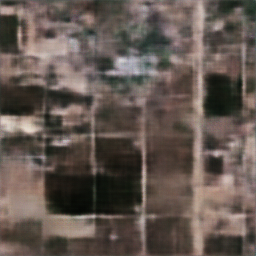

In [7]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from IPython.display import display  # Import display from IPython

torch.save(generator.state_dict(), '/kaggle/working/generator_model.pth')  # Save the model

# Load the trained generator model
generator = UNetGenerator().to(device)
generator.load_state_dict(torch.load('/kaggle/working/generator_model.pth', weights_only=True))
generator.eval()  # Set the model to evaluation mode

# Define the image transformation (same as during training)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load and preprocess the test SAR image
test_sar_image_path = '/kaggle/input/testttt/ROIs1970_fall_s1_29_p807.png'  # Path to your test SAR image
sar_image = Image.open(test_sar_image_path).convert('L')  # Convert to grayscale
sar_image = transform(sar_image).unsqueeze(0).to(device)  # Add batch dimension and move to GPU

# Generate the color image
with torch.no_grad():  # Disable gradient computation for inference
    gen_color = generator(sar_image)

# Postprocess the generated image
gen_color = gen_color.squeeze().cpu().numpy()  # Shape: (C, H, W)

# Denormalize the image (if needed)
gen_color = (gen_color * 0.5 + 0.5) * 255  # Rescale to [0, 255]
gen_color = np.clip(gen_color, 0, 255).astype(np.uint8)  # Ensure values are within [0, 255]

# Convert to PIL Image for visualization
gen_color_image = Image.fromarray(gen_color.transpose(1, 2, 0))  # Change to (H, W, C)

# Display the generated color image
display(gen_color_image)  # Show the image in the notebook

# Optionally, save the generated image to a file if you want
gen_color_image.save('/kaggle/working/generated_color_image.png')  # Save the image to a file